In [1]:
import camb
import pywigxjpf as pywig
from joblib import Parallel, delayed
import sys, argparse, multiprocessing
#from common import *
from scipy.signal import savgol_filter

In [2]:
import numpy as np
import healpy as hp
import matplotlib
import matplotlib.pyplot as plt
import os

In [3]:
nside = 2560

In [4]:
print("  Creating pywig tables...")
NSIDE_MAX = 4096
pywig.wig_table_init(3*nside, 3)
pywig.wig_temp_init(3*nside)

  Creating pywig tables...


In [105]:
L_RECONST_MAX = 25

In [81]:
def GammakSZ(l1, l2, l, Cltd) :
    pref = np.sqrt((2.0*l1+1)*(2.0*l2+1)*(2.0*l+1)/4.0/np.pi)
    wig = pywig.wig3jj(2*l1, 2*l2, 2*l, 0, 0, 0) # 2*[j1,j2,j3,m1,m2,m3]
    return pref*wig*Cltd[l2]

def getNinv(l, ls, Cltd, ClTT, Cldd) :
    Ninv = 0.0
    if l < L_RECONST_MAX+1 :
        print("Working on l =", l)
        for l1 in ls: # TODO: don't include monopole, dipole contributions?
            for l2 in ls:
                Ninv += GammakSZ(l1, l2, l, Cltd)**2 / ClTT[l1] / Cldd[l2]
        Ninv /= (2.0*l + 1.0)
    else :
        Ninv = 1.0e50 # N = 1.0e-50
    return Ninv

In [7]:
h=0.69
pars = camb.CAMBparams()
pars.set_cosmology(H0=100.0*h, ombh2=0.048*h**2, omch2=0.262*h**2, mnu=0.06, omk=0)
pars.InitPower.set_params(As=2e-9, ns=0.96, r=0)
pars.set_for_lmax(6144, lens_potential_accuracy=0)
results = camb.get_results(pars)
powers =results.get_cmb_power_spectra(pars, CMB_unit='K')
l=np.arange(0,len(powers['total'][:,0]))
cambFactor = l*(l+1)/(2*np.pi)
CMB_camb = powers['total'][:,0]/cambFactor
CMB_camb[0]=0.0

<ipython-input-7-d860381747c2>:10: RuntimeWarning: invalid value encountered in true_divide
  CMB_camb = powers['total'][:,0]/cambFactor


In [8]:
kSZ = np.load('./kSZ_NS_2560_R_2968_P_2048_DV_256_Sd_945986.npy')
overdensity = np.load('./overdensity_NS_2560_R_2968_P_2048_DV_256_Sd_945986.npy')
VelocityField = np.load('./VelocityField_NS_2560_R_2968_P_2048_DV_256_Sd_945986.npy')

In [9]:
rho_map = overdensity

ksz_PS = hp.anafast(kSZ)

CMB_map = hp.sphtfunc.synfast(CMB_camb,nside=nside);
    
Obs_T_map = kSZ + CMB_map

ClTT = hp.anafast(Obs_T_map)
ClTT_filtered = np.concatenate(([1.0], savgol_filter(ClTT[1:], 51, 3)))
Cldd = hp.anafast(rho_map)
Cltd = hp.anafast(rho_map, map2=-rho_map)
ls = np.arange(ClTT.size)
    
dTlm = hp.map2alm(Obs_T_map)
dlm = hp.map2alm(rho_map)

dTlm_resc = hp.almxfl(dTlm, 1.0/ClTT)
dT_resc = hp.alm2map(dTlm_resc, nside)
dlm = -1.0*dlm # dlm_resc = hp.almxfl(dlm, 1.0) #Cltd/Cldd
d_resc = hp.alm2map(dlm, nside)

/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:433: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  warnings.warn(
/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


In [107]:
#figuring out scaling factor
print("Scaling factor")
#Compute noise (expensive, need to optimize?)
print("Computing noise.")
ncores = multiprocessing.cpu_count()
lsMax=np.arange(5700)
Ninv = [ getNinv(l, lsMax, Cltd, ClTT, Cldd) for l in range(L_RECONST_MAX) ]
#Ninv = Parallel(n_jobs=ncores)(delayed(getNinv)(l, ls, Cltd, ClTT, Cldd) for l in ls)
N = 1.0/np.array(Ninv)
#N = np.zeros_like(ls, dtype=np.int)
#N[:100] = 1.0
    
unnorm_veff_reconstlm = hp.map2alm(dT_resc*d_resc,lmax=L_RECONST_MAX)
veff_reconstlm = hp.almxfl(unnorm_veff_reconstlm,fl=N)
unnorm_veff_reconst_ps = hp.alm2cl(unnorm_veff_reconstlm)
unnorm_veff_reconst = hp.alm2map(unnorm_veff_reconstlm, nside)
veff_reconst = hp.alm2map(veff_reconstlm, nside)


Scaling factor
Computing noise.
Working on l = 0
Working on l = 1
Working on l = 2
Working on l = 3
Working on l = 4
Working on l = 5
Working on l = 6
Working on l = 7
Working on l = 8
Working on l = 9
Working on l = 10
Working on l = 11
Working on l = 12
Working on l = 13
Working on l = 14
Working on l = 15
Working on l = 16
Working on l = 17
Working on l = 18
Working on l = 19
Working on l = 20
Working on l = 21
Working on l = 22
Working on l = 23
Working on l = 24


In [108]:
N

array([9.81155309e-16, 9.81330043e-16, 9.81421116e-16, 9.81547442e-16,
       9.81645404e-16, 9.81769212e-16, 9.81868297e-16, 9.81986818e-16,
       9.82090236e-16, 9.82207276e-16, 9.82311389e-16, 9.82426231e-16,
       9.82532583e-16, 9.82648204e-16, 9.82753157e-16, 9.82868394e-16,
       9.82975337e-16, 9.83091034e-16, 9.83196750e-16, 9.83312342e-16,
       9.83419458e-16, 9.83533048e-16, 9.83636625e-16, 9.83749074e-16,
       9.83854818e-16])

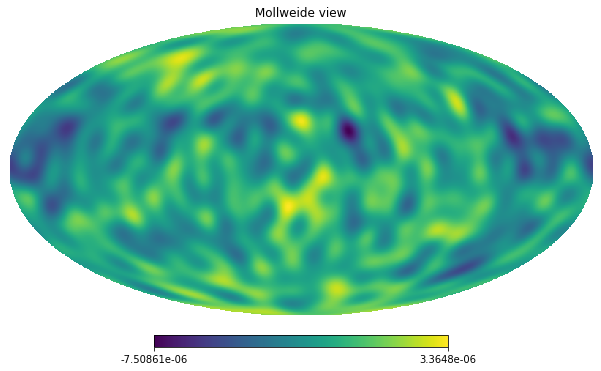

In [109]:
hp.mollview(veff_reconst)